# Projet de BIG DATA

# Exercice 1

## Question 1

In [1]:
from functools import reduce

# ------------------------ Fonction pour lire le fichier ------------------------

def lire_fichier(file_path):
    """
    Cette fonction lit le fichier contenant les relations d’amitié, 
    nettoie et retourne les données sous forme de liste de tuples 
    (utilisateur, set d'amis).
    """
    resultat = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Vérification que la ligne est bien structurée : "utilisateur: ami1, ami2, ..."
            if ':' in line and line[0].isdigit():
                utilisateur, amis = line.strip().split(':')
                amis_nettoyes = set()
                for ami in amis.split(','):
                    ami = ami.strip()
                    if ami.isdigit():  # On garde seulement les amis identifiés par des chiffres
                        amis_nettoyes.add(ami)
                resultat.append((utilisateur, amis_nettoyes))
    return resultat

# ------------------------ Fonction MAP : Générer les couples d'amis ------------------------

def mapper(user_friends):
    """
    Cette fonction crée une liste de couples (utilisateur, ami), où chaque couple
    représente un utilisateur et un de ses amis. Elle garde aussi les autres amis
    pour pouvoir trouver les amis en commun lors de la réduction.
    """
    user, friends = user_friends
    couples = []
    for friend in friends:
        pair = tuple(sorted((user, friend)))  # Création de la paire triée (utilisateur, ami)
        autres = [f for f in friends if f != friend]  # Liste des autres amis
        couples.append((pair, autres))  # Ajout du couple avec les autres amis
    return couples

# ------------------------ Fonction GroupByKey : Regrouper par clé ------------------------

def groupByKey(data):
    """
    Cette fonction groupe les éléments d'une liste de tuples (clé, valeur)
    par clé. Elle simule le groupByKey dans Spark.
    """
    result = {}
    for key, value in data:
        if key in result:
            result[key].append(value)
        else:
            result[key] = [value]
    return result

# ------------------------ Fonction ReduceByKey : Application d'une fonction de réduction ------------------------

def reduceByKey(f, data):
    """
    Cette fonction applique une fonction de réduction à chaque groupe d'éléments
    ayant la même clé. Elle simule le reduceByKey dans Spark.
    """
    grouped = groupByKey(data)  # Groupement des éléments par clé
    return [(key, reduce(f, grouped[key])) for key in grouped]

# ------------------------ Code principal ------------------------

if __name__ == "__main__":
    # Définition du chemin d'accès au fichier des relations d'amitié
    fichier_path = "C:/Users/t/Downloads/amis.txt"
    
    # Lecture des données et préparation sous forme de tuples (utilisateur, set(amis))
    data = lire_fichier(fichier_path)
    
    # Création d'un dictionnaire pour un accès rapide aux amis de chaque utilisateur
    friends_dict = {u: f for u, f in data}
    utilisateurs = sorted(friends_dict.keys())

    # ------------------------ Affichage des données nettoyées ------------------------

    print("Données nettoyées (extrait) :")
    for utilisateur, amis in data[:10]:
        print(f"Utilisateur : {utilisateur} → Amis : {sorted(list(amis))}")

    # ------------------------ Etape MAP : Transformation des données ------------------------

    couples = []
    for user_friends in data:
        couples.extend(mapper(user_friends))  # Générer tous les couples d'amis

    print("\nRésultats après Mapper (extrait) :")
    print(couples[:3])  # Affiche les 3 premiers couples générés

    # ------------------------ Etape GroupByKey : Regrouper les couples ------------------------

    grouped = groupByKey(couples)
    print("\nRésultat de groupByKey (extrait) :")
    print(dict(list(grouped.items())[:2]))  # Affiche les 2 premières paires groupées

    # ------------------------ Etape ReduceByKey : Trouver les amis en commun ------------------------

    def intersection_reducer(l1, l2):
        """
        Fonction de réduction : trouve l'intersection entre deux listes d'amis.
        """
        return list(set(l1) & set(l2))  # Retourne les amis en commun

    # Application de la réduction pour obtenir les amis en commun
    reduced = reduceByKey(intersection_reducer, couples)
    
    print("\nRésultat de reduceByKey (extrait) :")
    print(reduced[:3])  # Affiche les 3 premiers résultats après réduction

    # ------------------------ Résultat final : Affichage des amis en commun ------------------------

    print("\nRésultats finaux (amis en commun) :")
    for pair, amis in sorted(reduced):
        print(f"{pair}: {len(amis)} ami(s) en commun → {amis}")


Données nettoyées (extrait) :
Utilisateur : 10 → Amis : ['20', '30', '40']
Utilisateur : 20 → Amis : ['10', '30', '40']
Utilisateur : 30 → Amis : ['10', '20', '40', '50']
Utilisateur : 40 → Amis : ['10', '20', '30', '50']
Utilisateur : 50 → Amis : ['30', '40']

Résultats après Mapper (extrait) :
[(('10', '20'), ['30', '40']), (('10', '30'), ['20', '40']), (('10', '40'), ['20', '30'])]

Résultat de groupByKey (extrait) :
{('10', '20'): [['30', '40'], ['30', '40']], ('10', '30'): [['20', '40'], ['20', '40', '50']]}

Résultat de reduceByKey (extrait) :
[(('10', '20'), ['40', '30']), (('10', '30'), ['20', '40']), (('10', '40'), ['20', '30'])]

Résultats finaux (amis en commun) :
('10', '20'): 2 ami(s) en commun → ['40', '30']
('10', '30'): 2 ami(s) en commun → ['20', '40']
('10', '40'): 2 ami(s) en commun → ['20', '30']
('20', '30'): 2 ami(s) en commun → ['40', '10']
('20', '40'): 2 ami(s) en commun → ['30', '10']
('30', '40'): 3 ami(s) en commun → ['20', '10', '50']
('30', '50'): 1 ami(s)

## Question 2

In [1]:
from pyspark.sql import SparkSession

# ------------------------ Initialisation de Spark ------------------------

# Création de la session Spark
spark = SparkSession.builder \
    .appName("AmisEnCommun") \
    .getOrCreate()

# Récupération du contexte Spark
sc = spark.sparkContext

# ------------------------ Fonction pour lire et parser le fichier ------------------------

def lire_fichier(file_path):
    """
    Cette fonction lit un fichier et retourne les relations d'amitié sous forme de RDD.
    Chaque relation est nettoyée et convertie en tuple (utilisateur, set(amis)).
    """
    lignes = sc.textFile(file_path)
    
    # Filtrage des lignes qui ont un format valide
    lignes_filtrees = lignes.filter(lambda l: ':' in l and l[0].isdigit())

    # Fonction de parsing pour extraire les utilisateurs et leurs amis
    def parser(ligne):
        utilisateur, amis = ligne.strip().split(':')
        amis_nettoyes = set()
        for ami in amis.split(','):
            ami = ami.strip()
            if ami.isdigit():  # Garder uniquement les amis identifiés par des chiffres
                amis_nettoyes.add(ami)
        return (utilisateur.strip(), amis_nettoyes)

    return lignes_filtrees.map(parser)  # Transformation en RDD de tuples (utilisateur, set(amis))

# ------------------------ Fonction MAP : Transformation des données ------------------------

def mapper(user_friends):
    """
    Cette fonction effectue la transformation MAP : pour chaque utilisateur,
    elle génère des couples sous la forme (clé, valeir ) (utilisateur, ami) ainsi que la liste des autres amis.
    """
    user, friends = user_friends
    couples = []
    for friend in friends:
        pair = tuple(sorted((user, friend)))  # Création d'une paire triée (utilisateur, ami)
        autres = [f for f in friends if f != friend]  # Liste des autres amis
        couples.append((pair, autres))  # On garde cette information pour chaque couple
    return couples

# ------------------------ Fonction reduce : intersection des amis ------------------------

def intersection_reducer(l1, l2):
    """
    Fonction de réduction : elle effectue l'intersection entre deux listes d'amis,
    afin de trouver les amis en commun.
    """
    return list(set(l1) & set(l2))

# ------------------------ Programme principal ------------------------

if __name__ == "__main__":
    fichier_path = "C:/Users/PC/Downloads/amis.txt"

    # Lecture et nettoyage des données
    data = lire_fichier(fichier_path)

    # ------------------------ Affichage des données nettoyées ------------------------

    print("Données nettoyées (extrait) :")
    for utilisateur, amis in data.take(10):  # Affiche les 10 premières lignes
        print(f"Utilisateur : {utilisateur} → Amis : {sorted(list(amis))}")

    # ------------------------ Étape MAP : Transformation des données ------------------------

    # Appliquer la fonction MAP (flatMap permet de "déplier" la liste de résultats)
    couples = data.flatMap(mapper)

    print("\nRésultats après Mapper (extrait) :")
    print(couples.take(10)[:3])  # Affiche les 3 premiers couples générés

    # ------------------------ Étape groupByKey : Regrouper par clé ------------------------

    grouped = couples.groupByKey().mapValues(list)  # Groupement par clé (utilisateur, ami)
    grouped_list = grouped.take(2)  # Affiche les 2 premiers groupes

    # Format dict pour l'affichage
    grouped_dict = {k: [sorted(v) for v in vals] for k, vals in grouped_list}

    print("\nRésultat de groupByKey (extrait) :")
    print(grouped_dict)

    # ------------------------ Étape reduceByKey : Trouver les amis en commun ------------------------

    reduits = couples.reduceByKey(intersection_reducer)  # Réduction pour trouver les amis en commun
    reduits_list = reduits.take(10)  # Affiche les 10 premiers résultats

    print("\nRésultat de reduceByKey (extrait) :")
    print(reduits_list[:3])  # Affiche les 3 premiers résultats après réduction

    # ------------------------ Résultat final : Affichage des amis en commun ------------------------

    print("\nRésultats finaux (amis en commun) :")
    for pair, amis in reduits.sortByKey().collect():  # Tri des résultats et affichage
        print(f"{pair}: {len(amis)} ami(s) en commun → {sorted(amis)}")

    # ------------------------ Fermeture de Spark ------------------------

    # Arrêt de la session Spark pour libérer les ressources
    spark.stop()


Données nettoyées (extrait) :
Utilisateur : 10 → Amis : ['20', '30', '40']
Utilisateur : 20 → Amis : ['10', '30', '40']
Utilisateur : 30 → Amis : ['10', '20', '40', '50']
Utilisateur : 40 → Amis : ['10', '20', '30', '50']
Utilisateur : 50 → Amis : ['30', '40']

Résultats après Mapper (extrait) :
[(('10', '20'), ['40', '30']), (('10', '40'), ['20', '30']), (('10', '30'), ['20', '40'])]

Résultat de groupByKey (extrait) :
{('10', '20'): [['30', '40'], ['30', '40']], ('10', '40'): [['20', '30'], ['20', '30', '50']]}

Résultat de reduceByKey (extrait) :
[(('10', '20'), ['40', '30']), (('10', '40'), ['20', '30']), (('20', '40'), ['10', '30'])]

Résultats finaux (amis en commun) :
('10', '20'): 2 ami(s) en commun → ['30', '40']
('10', '30'): 2 ami(s) en commun → ['20', '40']
('10', '40'): 2 ami(s) en commun → ['20', '30']
('20', '30'): 2 ami(s) en commun → ['10', '40']
('20', '40'): 2 ami(s) en commun → ['10', '30']
('30', '40'): 3 ami(s) en commun → ['10', '20', '50']
('30', '50'): 1 ami(s)

# EXERCICE 2

In [11]:
"""
MapReduce-style Email and Word Frequency Extractor
Ce script analyse des pages web des restaurants, salons de coiffure et des hôtels à Paris pour extraire les adresses e-mail et les mots les plus fréquents.
Il utilise une approche similaire à MapReduce pour le traitement des données.
"""

import re
import urllib.request
from bs4 import BeautifulSoup
import os
from functools import reduce  # Fonction pour réduire une séquence à une valeur unique

# ----- FONCTIONS SIMULANT LE PARADIGME MAPREDUCE -----

def groupByKey(data):
    """
    Groupe les données par clé ( (l’étape map),).
    
    Args:
        data: Liste de tuples (clé, valeur)
    
    Returns:
        Dictionnaire avec les clés et les listes de valeurs correspondantes
    """
    result = {}
    for key, value in data:
        if key in result:
            result[key].append(value)
        else:
            result[key] = [value]
    return result


def reduceByKey(f, data):
    """
    Fonction de réduction des données par clé (équivalent à la phase reduce de MapReduce).
    
    Args:
        f: Fonction de réduction à appliquer sur les valeurs
        data: Liste de tuples (clé, valeur)
    
    Returns:
        Dictionnaire avec les clés et les valeurs réduites
    """
    key_values = groupByKey(data)
    return {key: reduce(f, values) for key, values in key_values.items()}


def map_reduce(words, top_k):
    """
    Applique le paradigme MapReduce pour compter les occurrences des mots.
    
    Args:
        words: Liste de mots à analyser
        top_k: Nombre de mots les plus fréquents à retourner
    
    Returns:
        Liste des top_k mots les plus fréquents avec leur nombre d'occurrences
    """
    # Phase Map: transformer chaque mot en paire (mot, 1), sans filtrage
    map_text = [(word.lower(), 1) for word in words]
    
    # Phase Reduce: sommer les occurrences pour chaque mot
    reduced_text = reduceByKey(lambda x, y: x + y, map_text)
    
    # Trier et limiter aux top_k mots
    return sorted(reduced_text.items(), key=lambda item: item[1], reverse=True)[:top_k]


# ----- FONCTIONS D'EXTRACTION ET DE TRAITEMENT -----

def extract_text_from_html(html_content):
    """
    Extrait le texte propre d'une page HTML en supprimant les balises et 
    en normalisant les espaces. On va utiliser la librairie BeautifulSoup pour y parvenir.
    
    Args:
        html_content: Contenu HTML à traiter
    
    Returns:
        Texte nettoyé extrait du HTML
    """
    # Parser html.parser, Récuperer les informations définies par les balises
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Supprimer les scripts et styles qui ne contiennent pas de texte utile
    for script_or_style in soup(['script', 'style']):
        script_or_style.decompose()
    
    # Extraire le texte et normaliser les espaces
    text = soup.get_text()
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


def get_valid_email_word(doc, top_k):
    """
    Fonction principale pour récupérer les emails et les mots fréquents à partir d'URLs.
    
    Args:
        doc: Chemin vers le fichier contenant les URLs à analyser
        top_k: Nombre de mots les plus fréquents à retourner pour chaque URL
    
    Returns:
        Dictionnaire avec les résultats pour chaque URL
    """
    result_dict = {}
    
    # Compiler l'expression reguliere associee aux adresses email des sites Web
    reMail = re.compile(r"[A-Za-z0-9\.\-+]+@[A-Za-z0-9\.\-+]+\.[a-zA-Z]{2,6}")
    
    # Regex pour extraire des mots
    reWord = re.compile(r"\b\w+\b")
    
    with open(doc, 'r') as f:
        for index, ligne in enumerate(f):
            ligne = ligne.strip()
            if not ligne:
                continue
                
            email_and_words = {"emails": [], "top_words": []}
            
            try:
                print(f"Traitement de l'URL: {ligne}")
                
                # Ajouter un User-Agent pour éviter d'être bloqué par certains sites
                headers = {'User-Agent': 'Mozilla/5.0'}
                req = urllib.request.Request(ligne, headers=headers)
                
                with urllib.request.urlopen(req, timeout=10) as page:
                    # Ouverture de la page sous forme de fichier et on le rend lisible en harmonisant le texte
                    contenu = page.read().decode('utf-8', errors='ignore')
                    clean_text = extract_text_from_html(contenu)
                    
                    # Extraire les emails visibles
                    email_and_words["emails"] = reMail.findall(clean_text)
                    
                    # Extraire et compter les mots avec MapReduce
                    words = reWord.findall(clean_text)
                    word_counts = map_reduce(words, top_k)
                    email_and_words["top_words"] = word_counts
                
                result_dict[ligne] = email_and_words
                
            except Exception as e:
                print(f"Erreur pour la page {ligne}: {e}")
                
    return result_dict


def save_results_to_file(results, output_file):
    """
    Sauvegarde les résultats dans un fichier texte formaté.
    
    Args:
        results: Dictionnaire contenant les résultats pour chaque URL
        output_file: Chemin du fichier de sortie
    """
    with open(output_file, 'w', encoding='utf-8') as f:
        for url, content in results.items():
            f.write(f"URL: {url}\n")
            
            f.write("Emails:\n")
            for email in content["emails"]:
                f.write(f"  - {email}\n")
                
            f.write("Top mots fréquents:\n")
            for word, count in content["top_words"]:
                f.write(f"  - {word}: {count}\n")
                
            f.write("\n" + "-"*50 + "\n\n")
            
    print(f"Résultats écrits dans {output_file}")


# ----- EXÉCUTION PRINCIPALE -----

if __name__ == "__main__":
    # Exécuter l'extraction pour les URLs dans le fichier spécifié
    results = get_valid_email_word("C:/Users/t/Downloads/URLs.txt", 10)
    
    # Sauvegarder les résultats dans un fichier
    save_results_to_file(results, "RESULTATS.txt")
    
    # Afficher le répertoire où le fichier a été enregistré
    print("Fichier enregistré dans :", os.getcwd())

Traitement de l'URL: https://restaurant-mun.com/paris/contact-us
Traitement de l'URL: https://gigi-restaurant.com/paris/contact-us
Traitement de l'URL: https://perruche-restaurant.com/paris/contact-us
Traitement de l'URL: https://benoit-paris.com/en/contact
Traitement de l'URL: https://restaurant-allard.fr/en/contact
Traitement de l'URL: https://david-mallett.com/en/salons/notre-dame
Traitement de l'URL: https://l-hotel.com/contact-directions
Traitement de l'URL: https://hotelrdeparis.com/en/p/3/contact
Résultats écrits dans RESULTATS.txt
Fichier enregistré dans : c:\Users\t\Downloads\BIG--DATA


# EXERCICE 3

Objectif : construire un modèle de score de crédit à partir du dataset HMEQ.
Approche :
- Analyse exploratoire et modélisation locale (Logistic Regression, Random Forest, XGBoost)
- Sélection du meilleur modèle (XGBoost)
- Entraînement et prédiction sur SageMaker

In [ ]:
#Import des packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report,
                             roc_curve, auc)

In [ ]:
#Import des packages pour SageMaker
import sagemaker
import  boto3, os
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.session import TrainingInput

c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\pydantic\_internal\_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/22/25 05:55:52] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=970919;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=826079;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py#1352\1352]8;;\

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\t\AppData\Local\sagemaker\sagemaker\config.yaml


In [ ]:
# Import des données  
df = pd.read_csv("C:/Users/t/Downloads/tab_credit.csv",sep=",")
print(df.shape)
df.head(5)

(5961, 13)


,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.37,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.83,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.47,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.33,0.0,14.0,NaN


## Analyse exploratoire des données

In [3]:
# Vérification des types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bad      5961 non-null   float64
 1   loan     5961 non-null   float64
 2   mortdue  5443 non-null   float64
 3   value    5849 non-null   float64
 4   reason   5709 non-null   object 
 5   job      5682 non-null   object 
 6   yoj      5446 non-null   float64
 7   derog    5253 non-null   float64
 8   delinq   5381 non-null   float64
 9   clage    5653 non-null   float64
 10  ninq     5451 non-null   float64
 11  clno     5739 non-null   float64
 12  debtinc  4694 non-null   float64
dtypes: float64(11), object(2)
memory usage: 605.5+ KB


In [19]:
# Analyse des valeurs manquantes
missing = df.isnull().mean().sort_values(ascending=False)
display("\nTaux de valeurs manquantes :\n", missing[missing > 0])

'\nTaux de valeurs manquantes :\n'

debtinc    0.212548
derog      0.118772
delinq     0.097299
mortdue    0.086898
yoj        0.086395
ninq       0.085556
clage      0.051669
job        0.046804
reason     0.042275
clno       0.037242
value      0.018789
dtype: float64

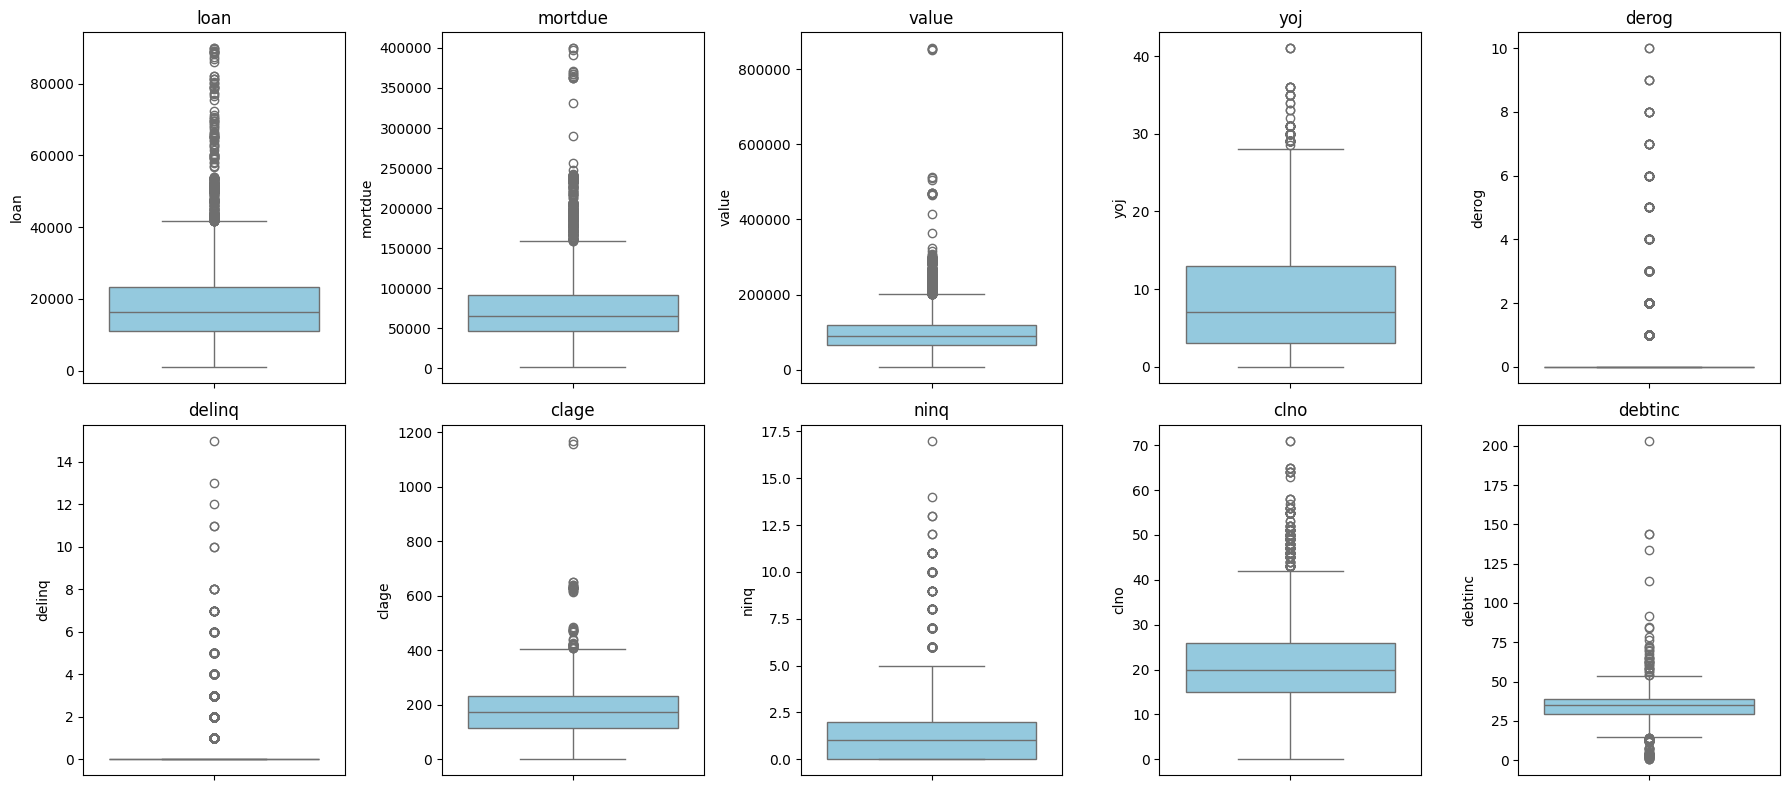

In [ ]:
#Voyons le comportement des outliers pour mieux adapter notre approche d'imputation ds valeurs manquantes

info_df_num = df.select_dtypes(include=['float64', 'int64'])

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

vars_to_plot = [v for v in info_df_num.columns if v != "bad"]

for i, v in enumerate(vars_to_plot):
    sns.boxplot(y=df[v], ax=axes[i], color='skyblue')
    axes[i].set_title(v)

plt.tight_layout()
plt.show()

Les variables numeriques ont beaucoup de valeurs extremes,on va donc adopter une approche d'imputation par la mediane pour ces dernieres.

## Séparation du jeu de données train/ test

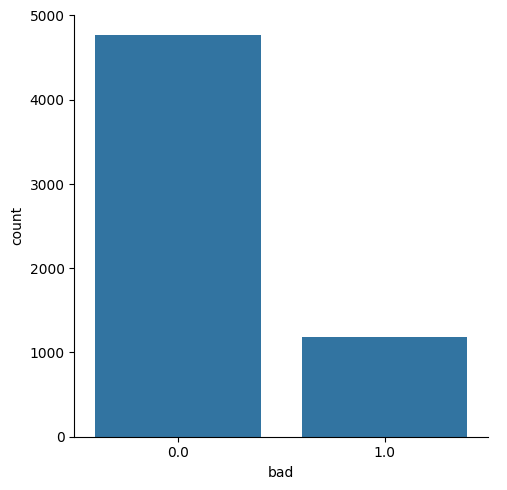

In [7]:
# définir la variable cible
target = "bad"
sns.catplot(x=target,kind="count",data=df)

In [8]:
# Distribution de la variable cible
print("\nDistribution de la variable cible bad :")
print(df[target].value_counts(normalize=True))


Distribution de la variable cible bad :
bad
0.0    0.800537
1.0    0.199463
Name: proportion, dtype: float64


La variable cible est désiquilibrée. Nous allons utiliser donc la notion d'échantillon stratifié : pour avoir la même répartion dans les 2 jeux de données Test et train.

In [9]:
#Création d'un jeu de données d'apprentissage, de test, on utilisera la methode cross validation pour valider les modeles

X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)  

## Traitement des variables catégorielles 

In [10]:
#Voyons combien de modalites par variables pour savoir comment les encoder

#def afficher_modalites_occurrences(df, exclude_cols=['Booking_ID']):
def afficher_modalites_occurrences(df):
    """ Affiche toutes les modalités et leurs occurrences pour chaque variable catégorielle """
    #categoricals = df.select_dtypes(include=['object', 'category']).drop(columns=exclude_cols, errors='ignore')
    categoricals = df.select_dtypes(include=['object', 'category'])
    
    for col in categoricals.columns:
        print(f"\n Modalités et occurrences pour '{col}':\n")
        print(df[col].value_counts())
        print("-" * 40)


afficher_modalites_occurrences(df)


 Modalités et occurrences pour 'reason':

reason
DebtCon    3929
HomeImp    1780
Name: count, dtype: int64
----------------------------------------

 Modalités et occurrences pour 'job':

job
Other     2389
ProfEx    1276
Office     948
Mgr        767
Self       193
Sales      109
Name: count, dtype: int64
----------------------------------------


Pour les 2 variables catégorielles, le nombre de modalités distinctes est assez faible, nous allons créer une variable indicatrice par modalité et les valeurs manquantes seront considérées comme une modalité à part entière.

In [12]:
# Pour les variables avec peu de modalité, passage en indicatrice
info_types = pd.DataFrame(df.dtypes)
list_var_cat_dum = info_types[info_types[0]=="object"].index.tolist()
 
# dummy_na = True : création d'une indicatrice pour les valeurs manquantes
X_train = pd.concat([X_train,pd.get_dummies(X_train[list_var_cat_dum],prefix=list_var_cat_dum,
                                  dummy_na = True,drop_first=True)],axis = 1)

X_test = pd.concat([X_test,pd.get_dummies(X_test[list_var_cat_dum],prefix=list_var_cat_dum,
                                  dummy_na = True,drop_first=True)], axis = 1)

In [13]:
#On supprime les variables initiales du jeu de donnees
X_train = X_train.drop(columns = ['reason', 'job'])
X_test = X_test.drop(columns = ['reason', 'job'])

## Imputation des données manquantes numeriques

Nous allons remplacer les valeurs manquantes par la médiane du jeu d'apprentissage.
Nous avons ainsi procede car dans une situation opérationnelle, on ne connait pas le jeu de donnees a predire, il faudra donc remplacer les valeurs manquantes par la médiane du jeu d'apprentissage du modele pour eviter des biais dans la prediction!

In [20]:
for v in info_df_num.columns.tolist():
    if v != target :
        tmp = X_train[v].isnull().sum() +X_test[v].isnull().sum()
        if tmp > 0 :
            v_missing = v + "_missing"
            X_train[v_missing] = np.where(X_train[v].isnull(),1,0)
            X_test[v_missing] = np.where(X_test[v].isnull(),1,0)
            median_app = X_train[v].median()
            X_train[v].fillna(median_app,inplace = True)
            X_test[v].fillna(median_app,inplace = True)   ##### --> Valeur de la moyenne de l'apprentissage

## Modélisation

In [15]:
#####  Standardisation des données pour la Régression Logistique #####
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

##### Régression Logistique #####
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000) #Utilisation de class_weight='balanced' pour gérer le déséquilibre de classes (20% de BAD = 1)
y_pred_log = cross_val_predict(logreg, X_train_scaled, y_train, cv=cv, method='predict')
y_prob_log = cross_val_predict(logreg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:, 1]

##### Random Forest avec GridSearch #####

rf_param_grid = {
    'n_estimators': [200, 500, 700],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42), # Utilisation de class_weight='balanced' pour gérer le déséquilibre de classes (20% de BAD = 1)
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
y_pred_rf = cross_val_predict(best_rf, X_train, y_train, cv = cv, method='predict')
y_prob_rf = cross_val_predict(best_rf, X_train, y_train, cv = cv, method='predict_proba')[:, 1]

##### XGBoost avec GridSearch #####
xgb_param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9]
}

xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
y_pred_xgb = cross_val_predict(best_xgb, X_train, y_train, cv=cv, method='predict')
y_prob_xgb = cross_val_predict(best_xgb, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:15:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:15:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:15:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:15:29] WARNING: C:\actions-runner\_work\

In [16]:
##### Comparaison des modèles #####

def eval_metrics(y_true, y_pred, y_proba):
    return {
        "AUC": roc_auc_score(y_true, y_proba),
        "Précision": precision_score(y_true, y_pred),
        "Rappel": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

results = {
    "Logistic Regression": eval_metrics(y_train, y_pred_log, y_prob_log),
    "Random Forest": eval_metrics(y_train, y_pred_rf, y_prob_rf),
    "XGBoost": eval_metrics(y_train, y_pred_xgb, y_prob_xgb)
}

# Print
df_results = pd.DataFrame(results).T.round(4)
print("\n Évaluation des modèles (CV sur X_train) :\n")
print(df_results)

# Meilleurs hyperparamètres des modèles ensemblistes
print("\n Meilleurs paramètres trouvés :\n")
print("Random Forest :", rf_grid.best_params_)
print("XGBoost       :", xgb_grid.best_params_)


 Évaluation des modèles (CV sur X_train) :

                        AUC  Précision  Rappel  F1-score
Logistic Regression  0.9059     0.6053  0.7981    0.6884
Random Forest        0.9567     0.8381  0.6719    0.7458
XGBoost              0.9584     0.8675  0.7476    0.8031

 Meilleurs paramètres trouvés :

Random Forest : {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}
XGBoost       : {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}


On voit que la regression logistique détecte beaucoup de défaillants(rappel : 0.7981),  mais a une faible précision (0.6053) il alerte a tort la banque.

Le Random Forest offre un excellent compromis entre précision et rappel (F1-score = 0.7458).

Le modele XGBoost pour sa part donne un meilleur compromis que le Random Forest et la regressin logistique (F1-score: 0.8031). Il distingue mieux les clients à risque, ceci en limitant les faux positifs. C’est le meilleur modèle en termes de performance globale.
Le modèle XGBoost est donc retenu comme modèle final et sera déployé dans SageMaker pour prédiction sur l’ensemble de test en utilisant les hyperparametres trouves par la methode Grid Search.

## Interpretabilite du meilleur modèle

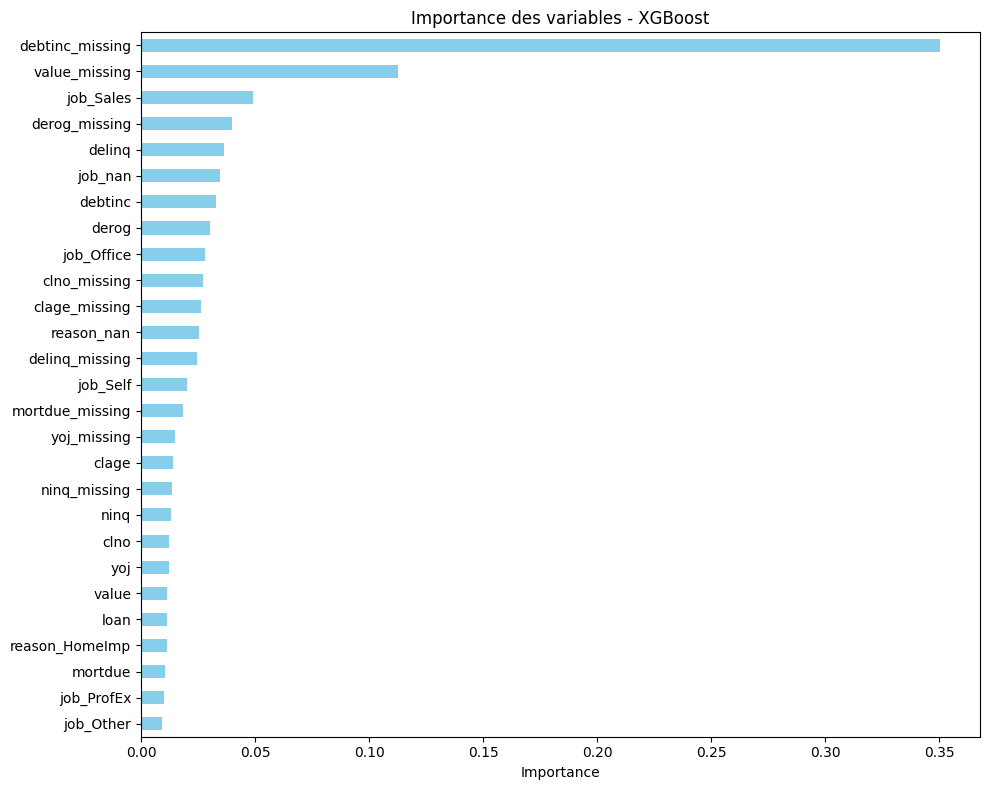

In [ ]:
# Importance des variables en considerant le meilleur modèle : XGBoost
importances = best_xgb.feature_importances_
feature_names = X_train.columns  # ou remplacer si tu as modifié l'ordre

# Affichage trié des importances
pd.Series(importances, index=feature_names).sort_values(ascending=True).plot(
    kind='barh', figsize=(10, 8), color='skyblue', title="Importance des variables - XGBoost"
)
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

On voit que le fait de ne pas connaître les variables debtinc (Ratio dette sur revenu) et value (valeur de la propriété) sont fortement lié à un risque de défaut. 
Les clients dont on ne connaît pas le revenu, pour pouvoir estimer leur taux d’endettement et pour lesquels ont n'a pas une estimation de la valeur de la propriété sont plus risqués.

## Entraînement et prédiction sur SageMaker

In [ ]:
# Préparation des données pour SageMaker
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

In [22]:
import pandas as pd
train = pd.concat([pd.Series(y_train, index=X_train.index,
                             name='bad', dtype=int), X_train], axis=1)
validation = pd.concat([pd.Series(y_val, index=X_val.index,
                            name='bad', dtype=int), X_val], axis=1)
test = pd.concat([pd.Series(y_test, index=X_test.index,
                            name='bad', dtype=int), X_test], axis=1)

In [23]:
train.head()

,bad,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,...,job_nan,mortdue_missing,value_missing,yoj_missing,derog_missing,delinq_missing,clage_missing,ninq_missing,clno_missing,debtinc_missing
4941,0,26100.0,73923.275118,36277.0,9.0,0.0,0.456112,79.33,1.188121,13.0,...,False,1,0,0,0,1,0,1,0,0
3749,0,19900.0,25589.000000,90051.0,8.0,0.0,0.000000,138.99,0.000000,20.0,...,False,0,0,0,0,0,0,0,0,0
780,0,8400.0,57103.000000,78079.0,0.0,0.0,0.000000,56.31,8.000000,21.0,...,False,0,0,0,0,0,0,0,0,0
5028,0,26700.0,81968.000000,114647.0,10.0,0.0,1.000000,126.71,0.000000,19.0,...,False,0,0,0,0,0,0,0,0,0
5775,0,46100.0,73923.275118,86132.0,10.0,0.0,0.000000,301.93,0.000000,13.0,...,False,1,0,0,0,0,0,0,0,0


In [24]:
# Use 'csv' format to store the data
# The first column is expected to be the output column
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)

In [25]:
# on initialise une session sagemaker
sess = sagemaker.Session()

[04/22/25 06:55:07] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=426009;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=875724;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py#1352\1352]8;;\

In [26]:
## Upload des donnees vers S3
bucket = "sagemaker-stevensia-2025"
prefix = "demo-sagemaker-BigData"

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/validation.csv')).upload_file('validation.csv')

[04/22/25 06:55:36] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=482213;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=356076;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py#1352\1352]8;;\

[04/22/25 06:55:39] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=90730;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=876691;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py#1352\1352]8;;\

In [ ]:
#Configuration de l'environnement SageMaker dans AWS pour accéder a S3, créer des endpoints etc

region = sagemaker.Session().boto_region_name #région AWS dans laquelle on travaille
print("AWS Region: {}".format(region))

role = "arn:aws:iam::518029234101:role/AmazonSageMakerExecutionRole-Stevensia" # Le rôle IAM dpermet a SageMaker de lire/écrire sur S3 de entraîner, déployer des modeles de ML
print("RoleArn: {}".format(role))

[04/22/25 06:56:17] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=59446;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=782281;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py#1352\1352]8;;\

AWS Region: eu-west-3
RoleArn: arn:aws:iam::518029234101:role/AmazonSageMakerExecutionRole-Stevensia


In [28]:
#sauvegarder le modèle XGBoost entraîné dans un dossier "xgboost_model"
s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

[04/22/25 06:56:49] INFO     Ignoring unnecessary instance type: None.                            ]8;id=337378;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=482133;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\image_uris.py#530\530]8;;\

659782779980.dkr.ecr.eu-west-3.amazonaws.com/sagemaker-xgboost:1.2-1


In [ ]:
# Définition du modèle XGBoost SageMaker, une seule instance pour l’hebergement, de type : 'ml.m5.xlarge'
xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size=3,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[
        Rule.sagemaker(rule_configs.create_xgboost_report()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport())
    ]
)

[04/22/25 06:58:01] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=127397;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=452622;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py#1352\1352]8;;\

[04/22/25 06:58:03] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=124959;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=3829;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\botocore\credentials.py#1352\1352]8;;\

In [ ]:
# Choix des hyperparamètres trouvés par la methode GridSearch pour l'entraînement du modele sur SageMaker
xgb_model.set_hyperparameters(
    max_depth = 7,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.8,
    objective = "binary:logistic",
    num_round = 500
)

In [ ]:
# Préparation des données pour entraînement avec le format requis par SageMaker
train_input = TrainingInput(
    "s3://{}/{}\{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}\{}".format(bucket, prefix, "data/validation.csv"), content_type="csv"
)

In [ ]:
#Entraînement du modèle sur SageMaker (dans le cloud)
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

[04/22/25 07:06:18] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=871496;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\telemetry\telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=498975;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\telemetry\telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=725303;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=53153;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\image_uris.py#530\530]8;;\

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=84558;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=1531;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name:                                       ]8;id=83688;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=29352;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-22-05-06-18-118                                             

2025-04-22 05:06:19 Starting - Starting the training job...
2025-04-22 05:06:52 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport: InProgress
...
2025-04-22 05:07:31 Downloading - Downloading the training image.....[2025-04-22 05:08:20.386 ip-10-0-140-213.eu-west-3.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[2025-04-22 05:

In [ ]:
# Déploiement du modèle entraîné (stocké sur S3)en endpoint
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

[04/22/25 07:10:12] INFO     Creating model with name: sagemaker-xgboost-2025-04-22-05-10-11-427    ]8;id=121929;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=274019;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\session.py#4094\4094]8;;\

[04/22/25 07:10:13] INFO     Creating endpoint-config with name                                     ]8;id=890589;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=747214;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\session.py#6019\6019]8;;\
                             sagemaker-xgboost-2025-04-22-05-10-11-427                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-04-22-05-10-11-427  ]8;id=978276;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=956374;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\session.py#4841\4841]8;;\

--------!

In [ ]:
# Afichage du nom du endpoint SageMaker qui a été créé lors du déploiement du modèle
xgb_predictor.endpoint_name

'sagemaker-xgboost-2025-04-22-05-10-11-427'

In [ ]:
# Prédiction sur X_test (déjà prêt et prétraité) par lot de 1000 lignes max (défaut = rows=1000).
import numpy as np
def predict(data, rows=1000):
    # Découpage des données en plusieurs petits tableaux de maximum 1000 lignes
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))

    predictions = '' # Chaîne de texte pour stocker toutes les prédictions

    # Pour chaque batch de données...
    for array in split_array:
        # Envoi du batch au modèle SageMaker, récupération de la prédiction sous forme texte et ajout à la chaîne des prédictions
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
        
        print(predictions)

    # Conversion de la chaîne en tableau NumPy (en ignorant la première virgule)
    return np.fromstring(predictions[1:], sep=',')

La fonction predict effectue des prédictions sur le jeu de données 'data' par batchs de 1000 lignes maximum.
Elle envoie chaque batch au modèle SageMaker déployé, récupère les prédictions, puis reconstruit un vecteur final avec toutes les probabilités.
    
    Paramètres :
    - data : tableau NumPy ou DataFrame transformé (float), sans la colonne cible.
    - rows : taille maximale de chaque batch envoyé au modèle (par défaut : 1000).
    
    Retour :
    - predictions : tableau NumPy des probabilités prédites pour chaque ligne.

In [ ]:
# Conversion de toutes les variables de X_test en int
test_clean = test.copy()

bool_cols = test_clean.select_dtypes(include='bool').columns
test_clean[bool_cols] = test_clean[bool_cols].astype(int)

test_clean = test_clean.astype(float)

,0.2773977816104889,0.11852703988552094,0.010515413247048855,0.013616691343486309,0.006433744914829731,0.0433109886944294,0.031877290457487106,0.004978642333298922,0.005746259354054928,0.03613923862576485,0.20304273068904877,0.010060315020382404,0.08923359960317612,0.19281230866909027,0.9908108711242676,0.1493971347808838,0.058951713144779205,0.019262488931417465,0.005035112611949444,0.08345314860343933,0.004199295770376921,0.9770888686180115,0.27422159910202026,0.21996183693408966,0.33779338002204895,0.997597873210907,0.007663318421691656,0.02441844902932644,0.2446136474609375,0.37681448459625244,0.005527537316083908,0.5546919107437134,0.9719304442405701,0.00950708519667387,0.07607660442590714,0.8680921792984009,0.07362200319766998,0.09218236804008484,0.027127394452691078,0.007876557298004627,0.04997487738728523,0.11873488128185272,0.0353606641292572,0.00457402691245079,0.3963072896003723,0.01429886743426323,0.024033060297369957,0.6170311570167542,0.9209426641464233,0.0064219506457448

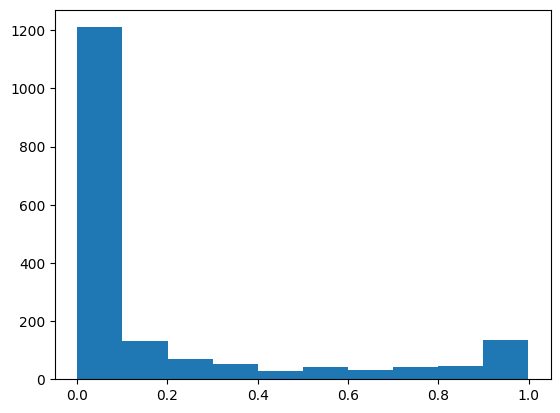

In [ ]:
# Prédictions et Histogramme (probabilités)
import matplotlib.pyplot as plt

predictions=predict(test_clean.to_numpy()[:,1:])

plt.hist(predictions)
plt.show()

L'histogramme montre la distribution des probabilités de défaut de paiement (BAD = 1) prédites par le modèle SageMaker XGBoost sur l'ensemble test.
On observe qu'environs 1200 observations ont une probabilité proche de 0, donc le modèle est très confiant que ces clients ne sont pas à risque
On observe aussi que moins de 300 des observations ont des probabilités superieures a 0.5, cela correspond aux cas que le modèle considère à risque élevé de défaut. Le modèle est donc peu incertain, il prend des décisions tranchées

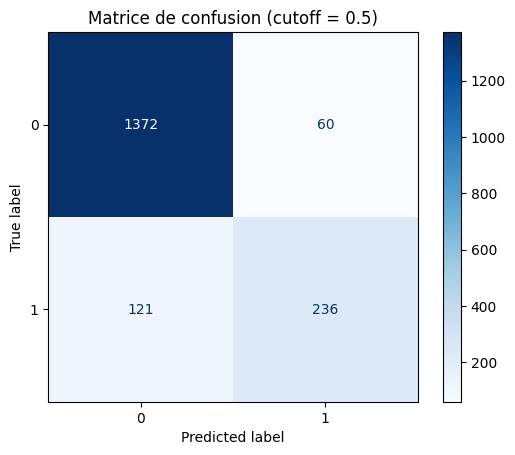

Évaluation du modele sur X_test :
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1432
           1       0.80      0.66      0.72       357

    accuracy                           0.90      1789
   macro avg       0.86      0.81      0.83      1789
weighted avg       0.89      0.90      0.90      1789



In [43]:
import sklearn
import matplotlib.pyplot as plt

cutoff = 0.5

# Matrice de confusion
cm = sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title(f"Matrice de confusion (cutoff = {cutoff})")
plt.grid(False)
plt.show()

# Rapport de classification
print("Évaluation du modele sur X_test :")
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

Le modèle est très bon pour détecter les non-défaillants (classe 0), precision et recall 0.92 et 0.96 respectivement.
Il est raisonnablement bon pour les défaillants, la précision est de 0.80, sur 100 clients prédits "défaillants", 80 le sont réellement; le rappel est de 0.66, le modèle détecte 66 % des vrais défaillants et donc 1/3 échappent à la détection.

In [44]:
#suppression de l'endpoint
xgb_model.delete_endpoint()

[04/22/25 07:34:56] WARNING  The function delete_endpoint is a no-op in sagemaker>=2.            ]8;id=765552;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\deprecations.py\deprecations.py]8;;\:]8;id=478152;file://c:\Users\t\AppData\Local\Programs\Python\Python312\Lib\site-packages\sagemaker\deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              